# Comparison of the performance of the models

Conduction of a comparison of classification performance and run-time for **Decision Tree Classifier**, **Random Forest Classifier** and **Gradient Boosting Classifier**.

RandomOverSampler is used to balance the training set.

GridSearchCV is used to find the best parameters for each model. The performance is evaluated on the test set.

Cross-validation is performed. 

The Built-in Feature Importance is used to find the most important features for each model.

Computing ROC AUC score for each model.

Training of models with only the most important features and parameter.

Steps:

1. Encoding using OneHotEncoder()
2. Applying RandomOverSampler()
3. Running pipeline per model with cv
4. Performing GridSearchCV() within pipeline for each model
5. Training of each model
6. Performing cross-validation on each model
7. Write results to df ['model_name', 'f1_score', 'accuracy', 'precision', 'recall', 'roc_auc',
                        'roc_curve', 'auc', 'cv_scores', 'feature_importances',
                        'best_parameters', 'execution_time', 'mean_cv_score', 'std_dev_cv_score']
8. Visualization of metrics for current models ['feature_importances', 'cv_scores','execution_time', 'roc_auc']
9. Training of each model with best parameter and most important features
10. Evaluation of each model


------------------------------------------------------------------------------------------------

changes from first version to current version
- change to RandomOverSampler
- changed scoring for cross-validation 
- feature importance changed from permutation to built-in
- roc auc added
- modified grid new: 
    - DecisionTreeClassifier:
            'model__max_depth': [None, 4, 10],
            'model__min_samples_split': [2, 5, 10]
    - RandomForestClassifier:
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 8, 10],
            'model__min_samples_split': [2, 5, 10]
    - GradientBoostingClassifier:
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.05, 0.1, 0.3]

- add std & mean to df
- add roc auc to df

In [1]:
# https://stackoverflow.com/questions/45150652/putting-together-sklearn-pipelinenested-cross-validation-for-knn-regression
# https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search
# https://stackoverflow.com/questions/16437022/how-to-tune-parameters-of-nested-pipelines-by-gridsearchcv-in-scikit-learn
# https://stackoverflow.com/questions/63698484/how-to-test-preprocessing-combinations-in-nested-pipeline-using-gridsearchcv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline

from sklearn.model_selection import (train_test_split, cross_validate, cross_val_score) 
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import time

import pickle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
random_state = 42
colors = ['darkgrey', 'purple', 'lightblue']
color = 'darkgrey'

In [3]:
df = pd.read_csv('kick_after_EDA.csv')

In [4]:
X = df.drop('IsBadBuy', axis=1)
y = df['IsBadBuy']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

**Encode categorical categories**

In [6]:
# Define the categorical feature
categorical_features = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'VNST']

# Write categorical columns to new dataframe
categorical_data_x_train = X_train[categorical_features]

# Write categorical columns to new dataframe
categorical_data_x_test = X_test[categorical_features]

In [7]:
def apply_one_hot_encoding(X_train, X_test, categorical_features):
    '''
    Encode categorical features:
    sklearn can currently handle numeric values
    '''
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')  # 'ignore' handles unseen categories
    print(f'Applying OneHotEncoder... ')
    # Fit the encoder on the training data and transform both train and test data
    encoded_x_train = encoder.fit_transform(X_train[categorical_features])
    encoded_x_test = encoder.transform(X_test[categorical_features])
    
    # Create new df with the encoded features
    encoded_columns = encoder.get_feature_names_out(categorical_features)
    encoded_x_train_df = pd.DataFrame(encoded_x_train, columns=encoded_columns, index=X_train.index)
    encoded_x_test_df = pd.DataFrame(encoded_x_test, columns=encoded_columns, index=X_test.index)
    
    # Concatenate encoded features with original numerical features
    X_train_encoded = pd.concat([encoded_x_train_df, X_train.drop(categorical_features, axis=1)], axis=1)
    X_test_encoded = pd.concat([encoded_x_test_df, X_test.drop(categorical_features, axis=1)], axis=1)
    
    return X_train_encoded, X_test_encoded

X_train_encoded, X_test_encoded = apply_one_hot_encoding(X_train, X_test, categorical_features)
print(f'Amount of features after using OneHotEncoder: {X_train_encoded.shape[1]}')
print(f'Amount of features after using OneHotEncoder: {X_test_encoded.shape[1]}')

Applying OneHotEncoder... 
Amount of features after using OneHotEncoder: 1990
Amount of features after using OneHotEncoder: 1990


**Split train test**

In [8]:
from collections import Counter
print(f'Original data set shape {Counter(y_train)}')

Original data set shape Counter({0: 42568, 1: 5982})


**Sampling of data set**

In [9]:
# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=random_state)
print(f'Applying RandomOverSampler... ')
# Apply RandomOverSampler to training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_encoded, y_train)

print(f'Original data set shape {Counter(y_train)}')
print(f'Original data set shape {Counter(y_train_resampled)}')


Applying RandomOverSampler... 


Original data set shape Counter({0: 42568, 1: 5982})
Original data set shape Counter({0: 42568, 1: 42568})


In [10]:
# Check if encoding and sampling of attributes worked properly
print(pd.np.mean(X_train[(y_train==1)]["CurrentAuctionAveragePrice"]))
print(pd.np.mean(X_train_resampled[(y_train_resampled==1)]["CurrentAuctionAveragePrice"]))
print(pd.np.mean(X_train_encoded[(y_train==1)]["VNST_TX"]))
print(pd.np.mean(X_train_resampled[(y_train_resampled==1)]["VNST_TX"]))

5488.968717755347
5492.823672989978
0.2089602139752591
0.20827851907536177


**Training of models**

including:
- GridSearch
- 5-fold cross-validation
- Feature importance
- Performance metrics

In [11]:
def ML(algName, X_train_resampled, y_train_resampled, X_test_encoded, y_test):
    # Model Building / Training
    print(f"Training {algName.__name__} model...")
    model = algName().fit(X_train_resampled, y_train_resampled)
    model_name = algName.__name__
    
    # Prediction
    y_pred = model.predict(X_test_encoded)
    
    # Success / Verification Score
    f1_metric = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr, tpr)

    # feature importances
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'tree_'):
        feature_importances = model.tree_.compute_feature_importances(normalize=False)
    else:
        feature_importances = None
    
    return {
        'model_name': model_name,
        'f1_score': f1_metric,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'roc_curve': (fpr, tpr),
        'auc': auc_value,
        'feature_importances': feature_importances
    }, model

models = [DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier]

results = []
for model_class in models:
    print(f"\nRunning pipeline for {model_class.__name__}...")
    start = time.time()  # Start the timer for each model
    
    # GridSearchCV
    param_grid = {}
    # parameter grid
    if model_class == DecisionTreeClassifier:
        param_grid = {
            'model__max_depth': [4, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [5],
            'model__random_state': [42]
        }
    elif model_class == RandomForestClassifier:
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 8, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__random_state': [42]
        }
    elif model_class == GradientBoostingClassifier:
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.05, 0.1, 0.3],
            'model__random_state': [42]
        }

    # pipeline with GridSearchCV
    pipeline = Pipeline([
        ('model', model_class())
    ])
    
    # GridSearchCV with cross-validation
    print(f"Performing GridSearchCV for {model_class.__name__}...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Extract the best parameters
    print(f"Extracting best param for {model_class.__name__}...")
    best_params = best_model.named_steps['model'].get_params()

    result, model = ML(model_class, X_train_resampled, y_train_resampled, X_test_encoded, y_test) 
    # Add best parameters to the result dictionary
    result.update({'best_parameters': best_params})

    fold_scores = []
    grid_search_results = grid_search.cv_results_
    mean_cv_scores = grid_search_results['mean_test_score']
    std_cv_scores = grid_search_results['std_test_score']
    
    for i in range(grid_search.n_splits_):
        fold_score = {
            'fold': i,
            'mean_cv_score': grid_search_results[f'split{i}_test_score'].tolist(),
            'std_cv_score': grid_search_results[f'split{i}_test_score'].std()
        }
        fold_scores.append(fold_score)
    
    result['fold_scores'] = fold_scores


    
    result['grid_mean_cv_scores'] = mean_cv_scores
    result['grid_std_cv_scores'] = std_cv_scores
    
    end = time.time()  # Stop the timer for the model
    model_time = end - start  # Calculate execution time for each model

    result['execution_time'] = model_time  # Add execution time to result dict
    results.append(result)

print('\nAll models processed...\n')

metrics = ['model_name', 'f1_score', 'accuracy', 'precision', 'recall', 'roc_auc', 'roc_curve', 'auc', 'feature_importances', 'execution_time']
print('\nWrite everything into df...')
classification = pd.DataFrame(results)


print(f'\n')

# Print execution time per model
for index, row in classification.iterrows():
    model_name = row['model_name']
    execution_time = row['execution_time']
    print(f'Execution time for {model_name}: {execution_time:.2f} seconds')

# print(f'\n')
for index, row in classification.iterrows():
    model_name = row['model_name']
    feature_importances = row['feature_importances']
    
    if feature_importances is not None:
        print(f'Feature importances for {model_name}: {feature_importances}')
    else:
        print(f'No feature importances for {model_name} available.')



Running pipeline for DecisionTreeClassifier...
Performing GridSearchCV for DecisionTreeClassifier...
Extracting best param for DecisionTreeClassifier...
Training DecisionTreeClassifier model...

Running pipeline for RandomForestClassifier...
Performing GridSearchCV for RandomForestClassifier...
Extracting best param for RandomForestClassifier...
Training RandomForestClassifier model...

Running pipeline for GradientBoostingClassifier...
Performing GridSearchCV for GradientBoostingClassifier...
Extracting best param for GradientBoostingClassifier...
Training GradientBoostingClassifier model...

All models processed...


Write everything into df...


Execution time for DecisionTreeClassifier: 380.95 seconds
Execution time for RandomForestClassifier: 1940.40 seconds
Execution time for GradientBoostingClassifier: 45979.82 seconds
Feature importances for DecisionTreeClassifier: [0.00309905 0.01184644 0.00385852 ... 0.09736071 0.0020191  0.04066089]
Feature importances for RandomForestClass

In [19]:
import pickle

# Save the results to a file
with open('saved_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# with open('saved_results.pkl', 'rb') as file:
#     loaded_results = pickle.load(file)

In [12]:
df_performance = classification.copy()

In [18]:
# write to .pkl
# df_performance.to_pickle('performance_comparison_results_1.pkl')


In [20]:
from joblib import dump, load

# Save the best models to files
for i, model in enumerate(models):
    model_filename = f'model_{i}.joblib'
    dump(model_name[i], model_filename)

# loaded_models = []
# for i in range(len(models)):
#     model_filename = f'model_{i}.joblib'
#     loaded_models.append(load(model_filename))

In [17]:
pd.set_option('max_colwidth', None)
df_performance.head()

,model_name,f1_score,accuracy,precision,recall,roc_auc,roc_curve,auc,feature_importances,best_parameters,fold_scores,grid_mean_cv_scores,grid_std_cv_scores,execution_time
0,DecisionTreeClassifier,0.227346,0.799615,0.215201,0.240943,0.559222,"([0.0, 0.12249857061177816, 1.0], [0.0, 0.24094326725905674, 1.0])",0.559222,"[0.003099048556035154, 0.011846444135724296, 0.0038585213116802833, 0.0002881919540979322, 0.00043488152042969925, 0.00033581750536363, 0.0011908624043858317, 0.0021092735432446815, 0.0022946316015470423, 0.0018551065521916605, 0.0004108995881225721, 0.0006474109306695439, 0.0, 0.0012933735890756511, 0.0, 7.491612802345193e-05, 0.0002633190951510615, 0.0005616082595326019, 0.0, 0.00016866952728567322, 0.0007300121732194452, 0.00015955348520086326, 0.0, 0.00025166129189047845, 0.0012072673336649949, 8.539874166636062e-05, 0.0, 0.0013489231246928226, 0.0008853485602153188, 0.0, 0.0, 0.0009296073133782088, 0.00037069500883151195, 0.0, 0.0, 0.0004961476695133415, 0.0, 8.063322231975249e-05, 0.0, 0.0005109218459383942, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018952119259447602, 0.0, 0.0, 4.240959374554721e-05, 0.0, 0.0002995619515993287, 0.0001096285159431185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00029012566374781725, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00024022879848261566, 0.0, 0.0, 0.0, 4.287141738041493e-05, 0.00038365983896611084, 0.0, 0.0, 0.0, 0.0, 0.000192916877825728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00016812939881944298, 0.0, 8.333728996721194e-06, 0.0, 0.0, 0.0, 0.00021706853577681436, 0.00010900030408306718, 0.0, 0.0, 0.0, 0.0, ...]","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}","[{'fold': 0, 'mean_cv_score': [0.6731227343345417, 0.6731227343345417, 0.6731227343345417, 0.6073914694342487, 0.6073914694342487, 0.6073914694342487, 0.7072168337991124, 0.7072168337991124, 0.7072168337991124], 'std_cv_score': 0.041430142240041073}, {'fold': 1, 'mean_cv_score': [0.6159302675082657, 0.6159302675082657, 0.6159302675082657, 0.6113510178901912, 0.6113510178901912, 0.6113510178901912, 0.6964941569282138, 0.6964941569282138, 0.6964941569282138], 'std_cv_score': 0.0391022362685056}, {'fold': 2, 'mean_cv_score': [0.6715520877266975, 0.6715520877266975, 0.6715520877266975, 0.6445481049562682, 0.6445481049562682, 0.6445481049562682, 0.7118344827586207, 0.7118344827586207, 0.7118344827586207], 'std_cv_score': 0.027647268446015626}, {'fold': 3, 'mean_cv_score': [0.6414223822652338, 0.6414223822652338, 0.6414223822652338, 0.6432863415761498, 0.6432863415761498, 0.6432863415761498, 0.7005341642555085, 0.7005341642555085, 0.7005341642555085], 'std_cv_score': 0.02743677644635593}, {'fold': 4, 'mean_cv_score': [0.6295472310744994, 0.6295472310744994, 0.6295472310744994, 0.630793689617219, 0.630793689617219, 0.630793689617219, 0.708395760501637, 0.708395760501637, 0.708395760501637], 'std_cv_score': 0.03687927098771993}]","[0.6463149405818477, 0.6463149405818477, 0.6463149405818477, 0.6274741246948154, 0.6274741246948154, 0.6274741246948154, 0.7048950796486185, 0.7048950796486185, 0.7048950796486185]","[0.022732764762300794, 0.022732764762300794, 0.022732764762300794, 0.015593807304779534, 0.015593807304779534, 0.015593807304779534, 0.005574831116961473, 0.005574831116961473, 0.005574831116961473]",380.948006
1,RandomForestClassifier,0.127315,0.873881,0.415094,0.075188,0.530209,"([0.0, 0.014770344959024205, 1.0], [0.0, 0.07518796992481203, 1.0])",0.530209,"[0.007995241887694701, 0.010277301691551865, 0.007321956932898786, 0.00012115749732735342, 0.0006671570159118748, 0.0001111211156441017, 0.0030090584732834972, 0.002343569294003933, 0.0027342527069579995, 0.00244439503317117, 0.0004894181879193335, 0.0003964666448053995, 2.0339849899698087e-06, 0.001061487750379436, 9.466938218959986e-05, 0.00

CV SCORES

In [16]:
df_expanded = df_performance.explode('fold_scores')

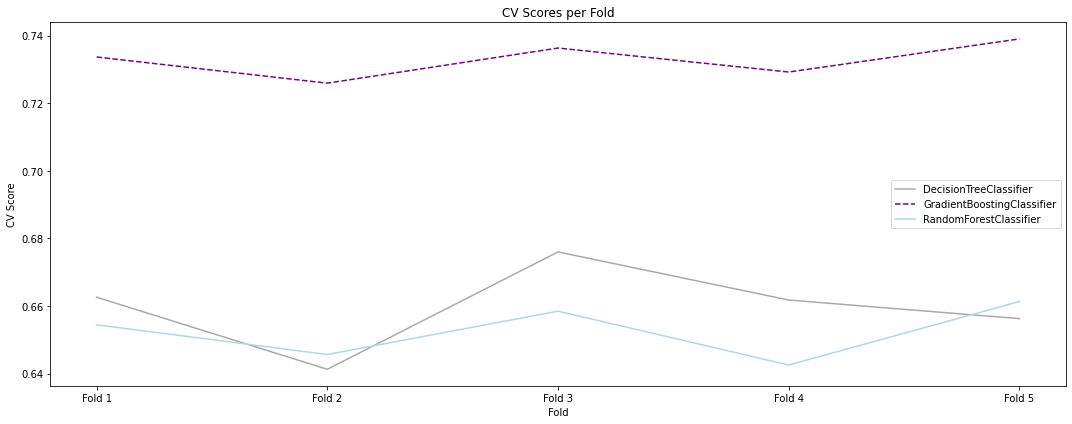

In [18]:
df_expanded['cv_score'] = df_expanded['fold_scores'].apply(lambda x: sum(x.get('mean_cv_score', [])) / len(x.get('mean_cv_score', [])))
df_expanded['fold'] = df_expanded['fold_scores'].apply(lambda x: x.get('fold'))

colors = ['darkgrey', 'purple', 'lightblue']
linestyles = ['-', '--', 'solid']
linewidths = [2, 2, 2]

plt.figure(figsize=(15, 6))

for i, (model_name, group_df) in enumerate(df_expanded.groupby('model_name')):
    plt.plot(group_df['fold'], group_df['cv_score'], color=colors[i], linestyle=linestyles[i], label=model_name)

plt.xlabel('Fold')
plt.ylabel('CV Score')
plt.title("CV Scores per Fold")
plt.legend(loc='right')
fold_labels = ['Fold {}'.format(i + 1) for i in range(len(df_expanded['fold'].unique()))]
plt.xticks(df_expanded['fold'].unique(), fold_labels)
plt.tight_layout()
plt.show()

Feature importance

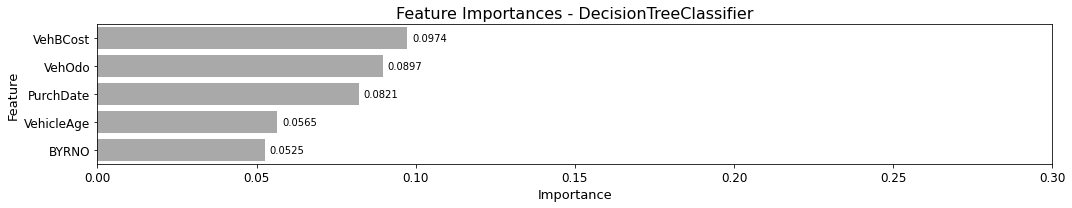

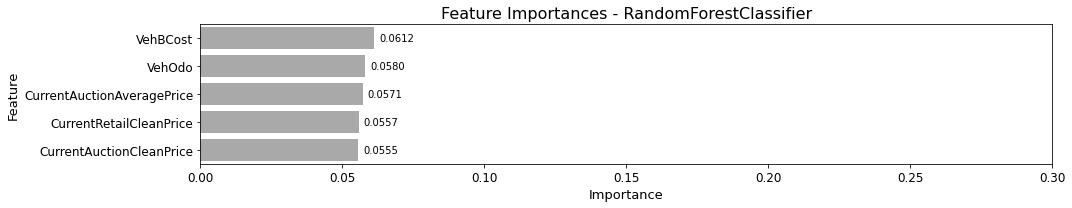

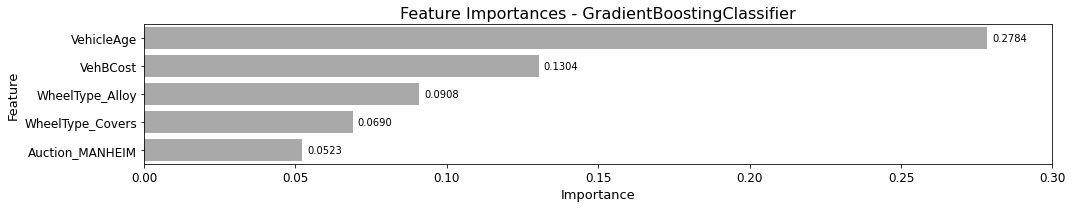

In [20]:
# plot feature importance TOP 5
model_indices = [0, 1, 2]  
model_names = {
    0: 'DecisionTreeClassifier',
    1: 'RandomForestClassifier',
    2: 'GradientBoostingClassifier'
} 

for model_index in model_indices:
    feature_importances = df_performance.loc[model_index, 'feature_importances']
    feature_names = X_train_resampled.columns
    
    normalized_importances = (feature_importances - feature_importances.min()) / (feature_importances.max() - feature_importances.min())

    # sort in df
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(15, 3))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_imp_df[:5], color=color)
    
    # Set y-axis limits to unify the scale
    plt.xlim(0, .3)
    num_ticks = 11  
    #plt.xticks(ticks=[i/20 for i in range(num_ticks)])
    for p in ax.patches:
        ax.annotate("%.4f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
    ax.tick_params(axis='x', labelsize=12) 
    ax.tick_params(axis='y', labelsize=12) 
    plt.title(f'Feature Importances - {model_names[model_index]}', fontsize=16)
    plt.xlabel('Importance', fontsize=13)
    plt.ylabel('Feature', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_names[model_index]}.svg')    
    plt.show()


In [23]:
for model_index in model_indices:
    feature_importances = df_performance.loc[model_index, 'feature_importances']
    feature_names = X_train_resampled.columns
    
    normalized_importances = (feature_importances - feature_importances.min()) / (feature_importances.max() - feature_importances.min())

    # sort in df
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
    
    top_features = feature_imp_df[:5]  # Get the top 5 features

    # Print the top 5 feature importances for the current model
    print(f"Top 5 Feature Importances for {model_names[model_index]}:")
    for i, row in top_features.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

Top 5 Feature Importances for DecisionTreeClassifier:
VehBCost: 0.0974
VehOdo: 0.0897
PurchDate: 0.0821
VehicleAge: 0.0565
BYRNO: 0.0525
Top 5 Feature Importances for RandomForestClassifier:
VehBCost: 0.0612
VehOdo: 0.0580
CurrentAuctionAveragePrice: 0.0571
CurrentRetailCleanPrice: 0.0557
CurrentAuctionCleanPrice: 0.0555
Top 5 Feature Importances for GradientBoostingClassifier:
VehicleAge: 0.2784
VehBCost: 0.1304
WheelType_Alloy: 0.0908
WheelType_Covers: 0.0690
Auction_MANHEIM: 0.0523


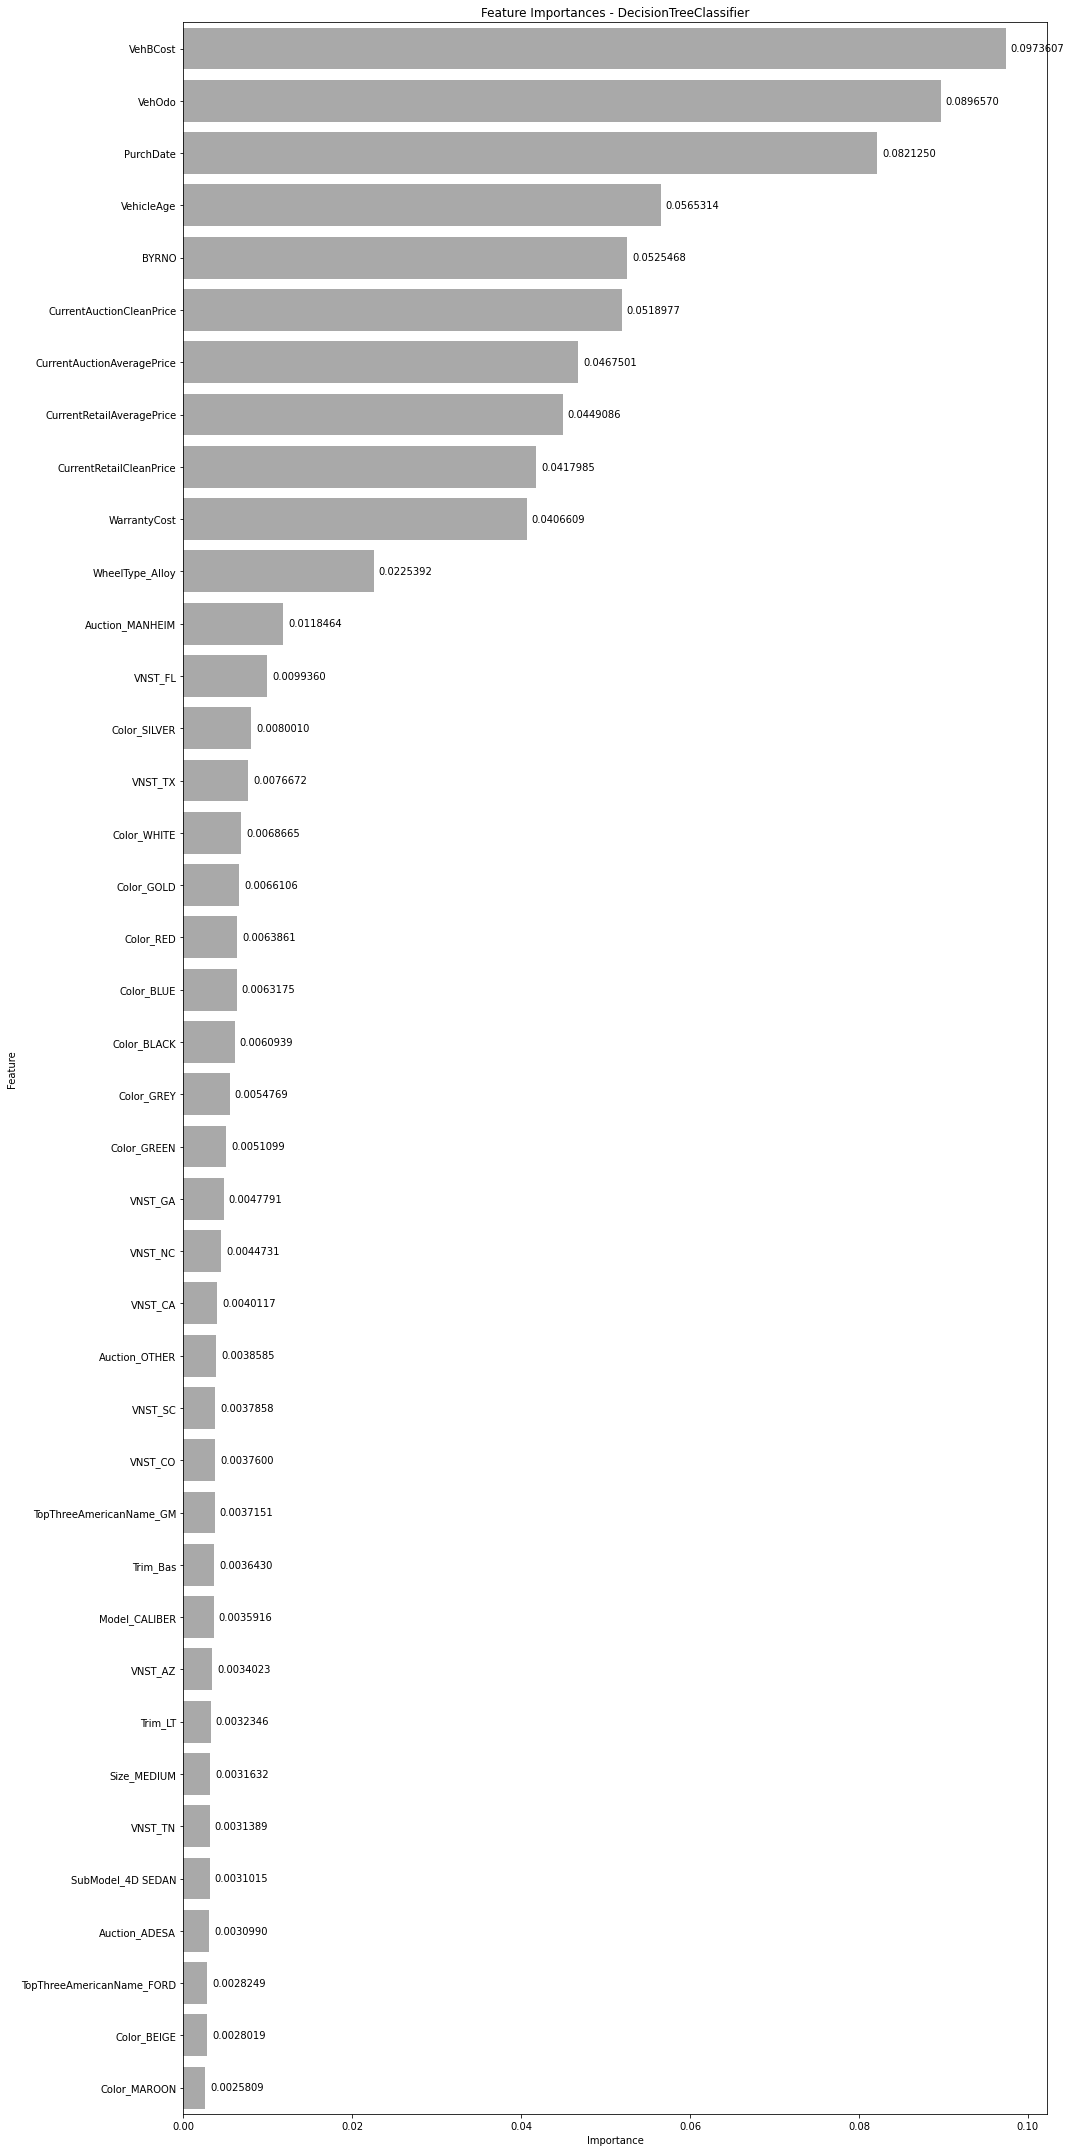

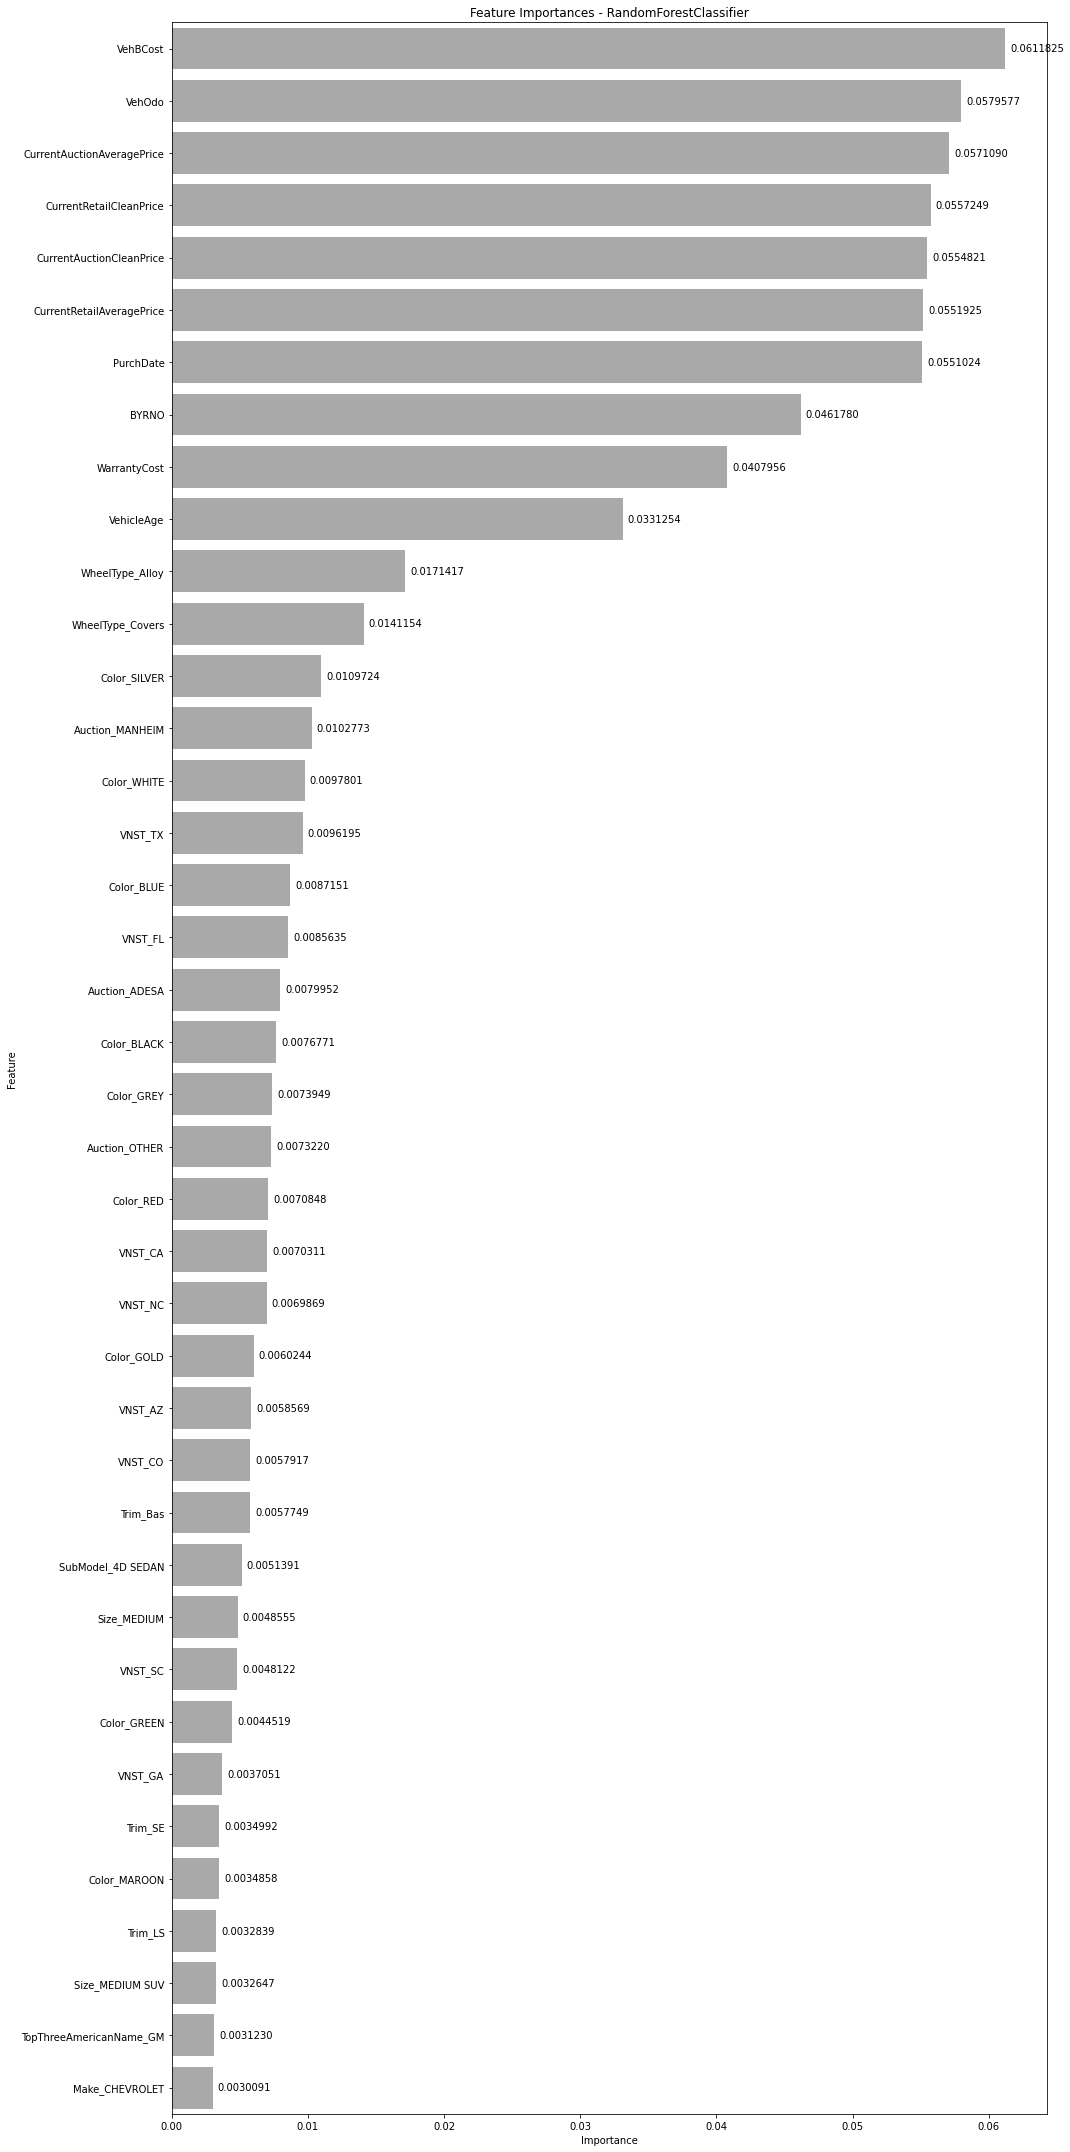

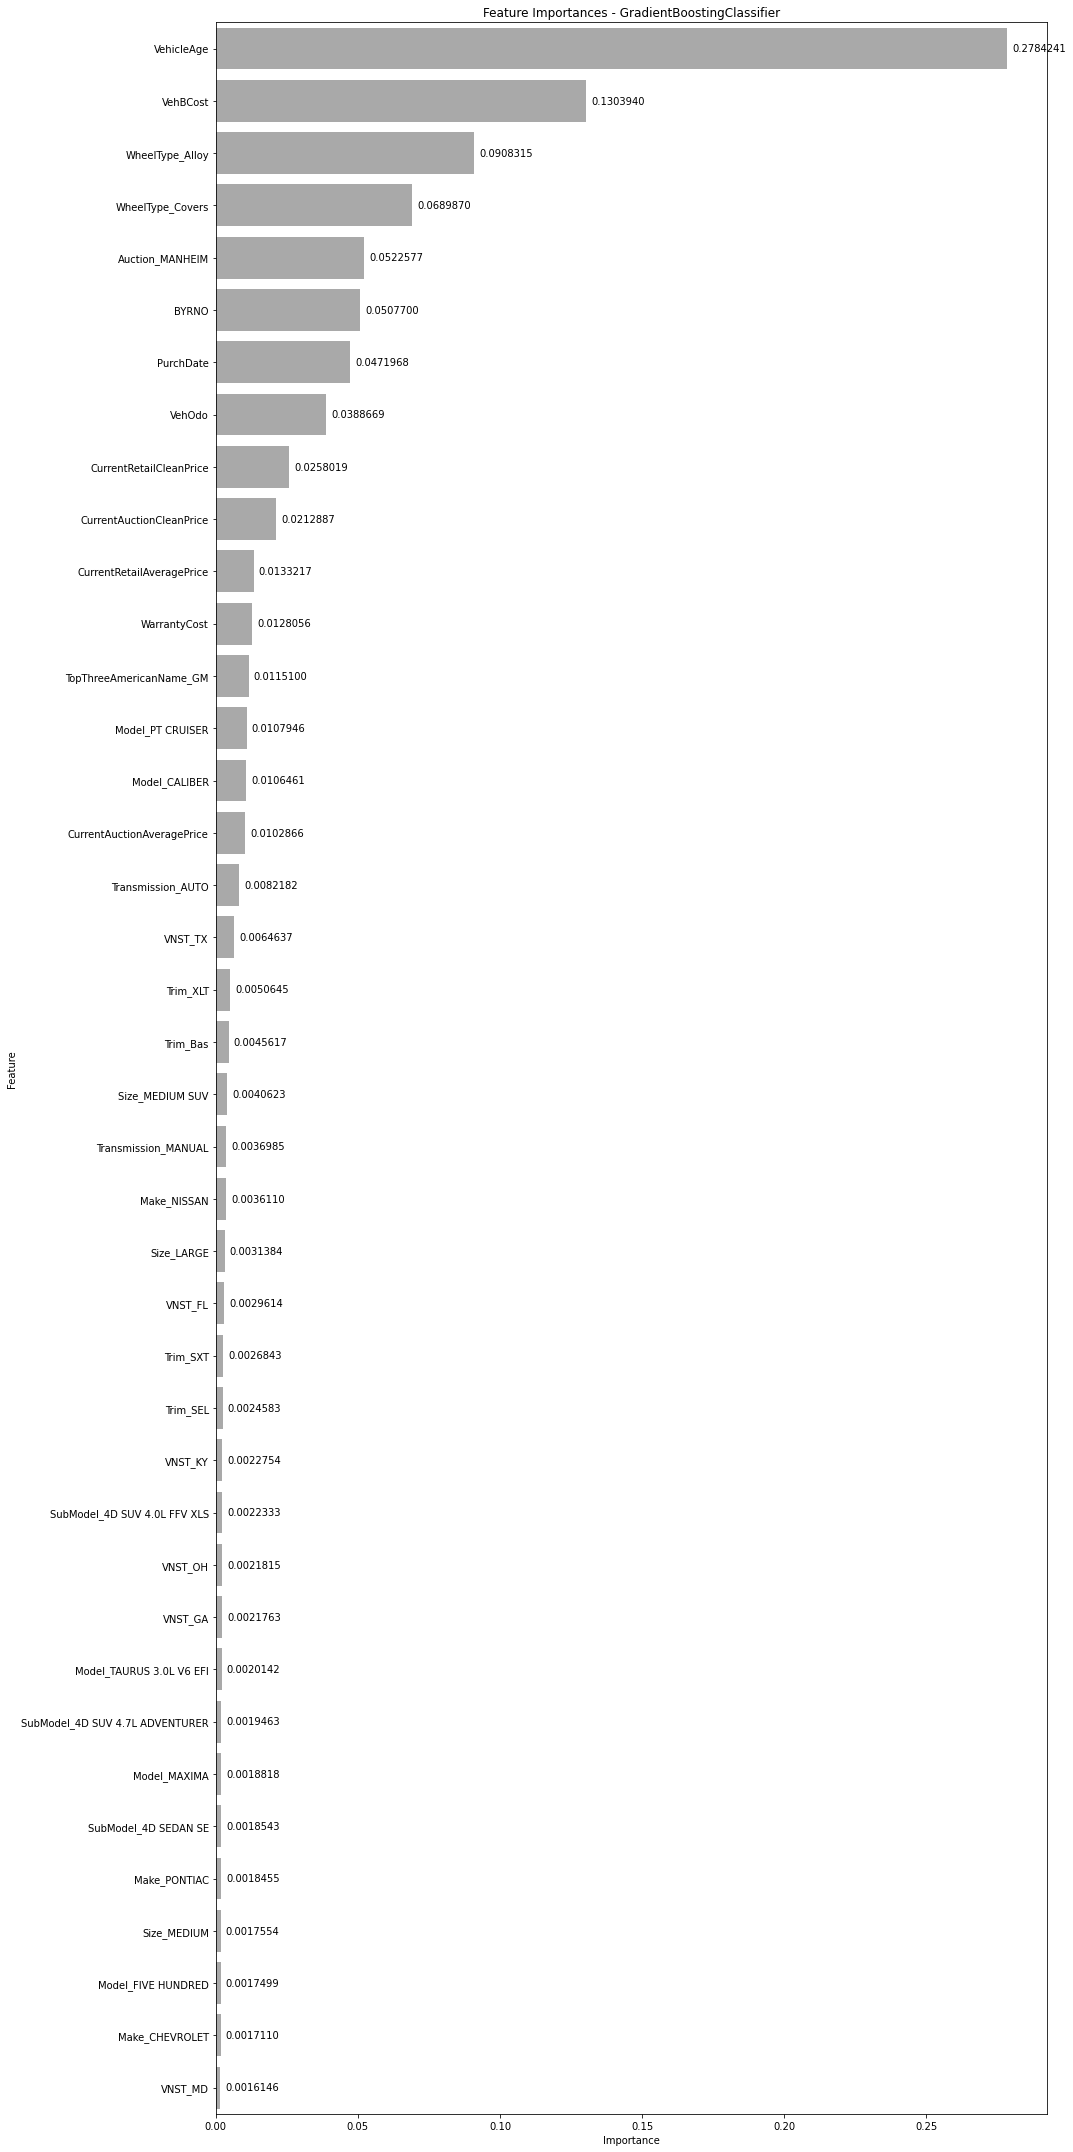

In [25]:
# plot feature importance
model_indices = [0, 1, 2]  
model_names = {
    0: 'DecisionTreeClassifier',
    1: 'RandomForestClassifier',
    2: 'GradientBoostingClassifier'
} 

for model_index in model_indices:
    feature_importances = df_performance.loc[model_index, 'feature_importances']
    feature_names = X_train_resampled.columns

    # sort in df
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(15, 30))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_imp_df[:40], color=color)  

    for p in ax.patches:
        ax.annotate("%.7f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
    plt.title(f'Feature Importances - {model_names[model_index]}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



Execution time

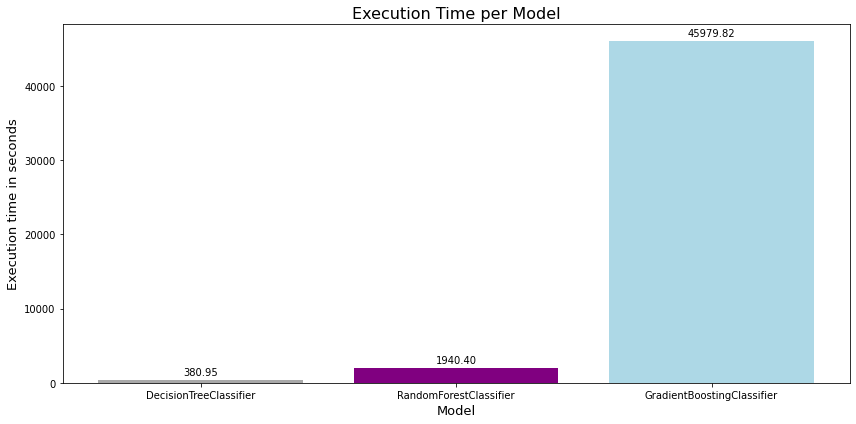

In [26]:
# plot execution_time
plt.figure(figsize=(12, 6))
bars = plt.bar(df_performance['model_name'], df_performance['execution_time'], color=colors)
plt.xlabel('Model', fontsize=13)
plt.ylabel('Execution time in seconds', fontsize=13)
plt.title('Execution Time per Model', fontsize=16)
plt.xticks()
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.savefig(f'runtime.svg') 
plt.show()

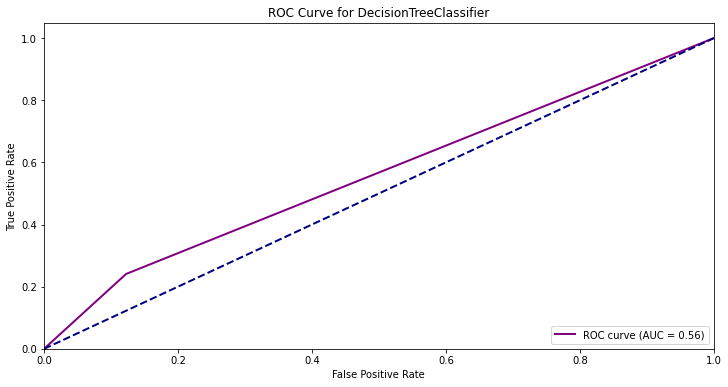

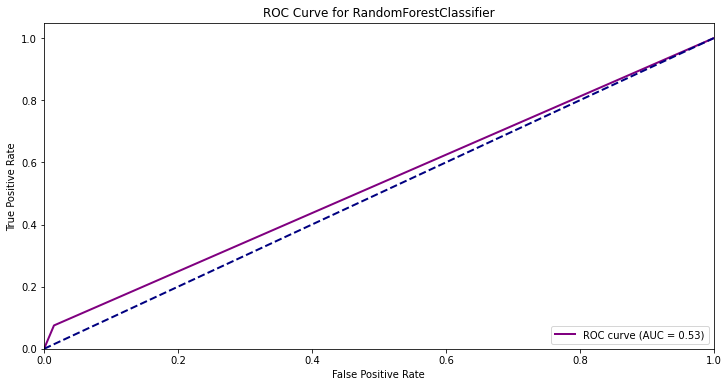

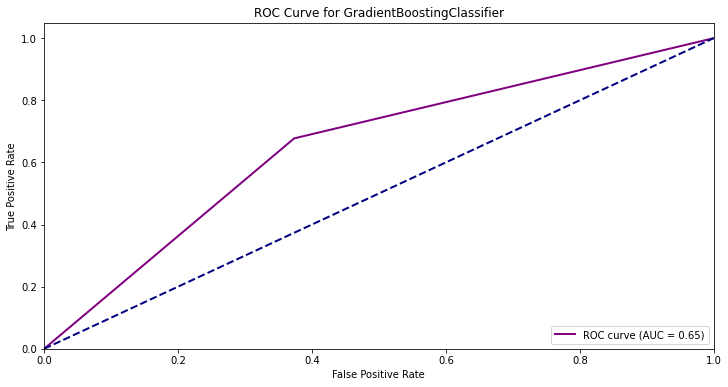

In [27]:
for index, row in df_performance.iterrows():
    model_name = row['model_name']
    fpr, tpr = row['roc_curve']
    roc_curve_auc = row['roc_auc'] 
    
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_curve_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'ROC_curve_{model_names[model_index]}.svg')    

    plt.show()

**Feature Importance**

In [28]:
def select_features(df_performance, X_train_resampled):
    '''
    Takes df and X_train_resampled features and cuts
    the most important features per model
    '''
    threshold_dt = 0.0002547
    threshold_rf = 0.0002073
    threshold_gb = 0.0010137
    
    # Extract the feature importances for each model from df, store features
    feature_importances_dt = df_performance[df_performance['model_name'] == 'DecisionTreeClassifier']['feature_importances'].iloc[0]
    feature_importances_rf = df_performance[df_performance['model_name'] == 'RandomForestClassifier']['feature_importances'].iloc[0]
    feature_importances_gb = df_performance[df_performance['model_name'] == 'GradientBoostingClassifier']['feature_importances'].iloc[0]
    
    # Filter features based on the defined thresholds from X_train_resampled
    most_important_features_dt = np.array(X_train_resampled.columns)[feature_importances_dt >= threshold_dt]
    most_important_features_rf = np.array(X_train_resampled.columns)[feature_importances_rf >= threshold_rf]
    most_important_features_gb = np.array(X_train_resampled.columns)[feature_importances_gb >= threshold_gb]
    
    return (most_important_features_dt, most_important_features_rf, most_important_features_gb)

selected_dt, selected_rf, selected_gb = select_features(df_performance, X_train_resampled)
# results are assigned to selected_dt, selected_rf, selected_gb


In [ ]:
# print(f"Most important features for Decision Tree: {selected_dt}")
# print(f"Most important features for Random Forest: {selected_rf}")
# print(f"Most important features for Gradient Boosting: {selected_gb}")

In [31]:
count_dt = len(selected_dt)
print(f"Amount of features for Decision Tree Classifier: {count_dt}")
count_rf = len(selected_rf)
print(f"Amount of features for Random Forest Classifier: {count_rf}")
count_gb = len(selected_gb)
print(f"Amount of features for Gradient Boosting Classifier: {count_gb}")

Amount of features for Decision Tree Classifier: 293
Amount of features for Random Forest Classifier: 353
Amount of features for Gradient Boosting Classifier: 61


In [32]:
# df with important features
X_train_dt = X_train_resampled[selected_dt]
X_train_rf = X_train_resampled[selected_rf]
X_train_gb = X_train_resampled[selected_gb]


## FINAL TRAINING WITH MOST IMPORTANT FEATURE AND BEST PARAMETER

### GradientBoostingClassifier FINAL

In [49]:
# only best params
start_time_gb = time.time()
gb_model_final = GradientBoostingClassifier(ccp_alpha= 0.0, criterion= 'friedman_mse', init= None, 
        learning_rate= 0.3, loss= 'log_loss', max_depth= 7, 
        max_features= None, max_leaf_nodes= None, min_impurity_decrease= 0.0, 
        min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf= 0.0, 
        n_estimators= 200, n_iter_no_change= None, random_state= random_state, 
        subsample= 1.0, tol= 0.0001, validation_fraction= 0.1, verbose= 0, warm_start= False)


gb_model_final.fit(X_train_gb, y_train_resampled)
end_time_gb = time.time()

In [50]:
y_pred = gb_model_final.predict(X_train_gb)

target_names=['Class 0', 'Class 1']
print(classification_report(y_train_resampled, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

     Class 0    0.98398   0.95111   0.96727     42568
     Class 1    0.95269   0.98452   0.96834     42568

    accuracy                        0.96782     85136
   macro avg    0.96834   0.96782   0.96781     85136
weighted avg    0.96834   0.96782   0.96781     85136



In [51]:
# roca auc GB final
from sklearn.metrics import roc_auc_score

# Predict the probabilities of the positive class
y_prob = gb_model_final.predict_proba(X_train_gb)[:, 1]

# Calculate the ROC AUC score
roc_auc_gb = roc_auc_score(y_train_resampled, y_prob)

print("ROC AUC Score:", roc_auc_gb)


ROC AUC Score: 0.9954761557028615


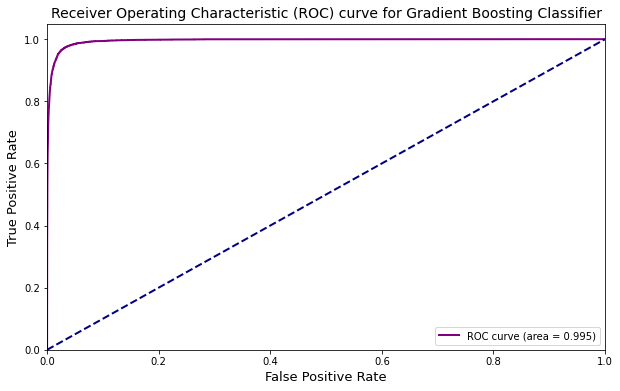

In [52]:
# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_train_resampled, y_prob)
gb_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.3f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic (ROC) curve for Gradient Boosting Classifier', fontsize=14)
plt.legend(loc="lower right")
plt.savefig(f'roc_gb.svg') 
plt.show()


### DecisionTreeClassifier FINAL

In [53]:
# only best params
start_time_dt = time.time()
dt_model_final = DecisionTreeClassifier(ccp_alpha= 0.0, class_weight= None, criterion= 'gini', 
                                        max_depth= 10, max_features= None, max_leaf_nodes= None, min_impurity_decrease= 0.0, 
                                        min_samples_leaf= 5, min_samples_split= 2, min_weight_fraction_leaf= 0.0, random_state= 42, splitter= 'best')

# only important features
dt_model_final.fit(X_train_dt, y_train_resampled)
end_time_dt = time.time()

In [54]:
y_pred = dt_model_final.predict(X_train_dt)

target_names=['Class 0', 'Class 1']
print(classification_report(y_train_resampled, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

     Class 0    0.73491   0.64704   0.68818     42568
     Class 1    0.68473   0.76661   0.72336     42568

    accuracy                        0.70682     85136
   macro avg    0.70982   0.70682   0.70577     85136
weighted avg    0.70982   0.70682   0.70577     85136



In [55]:
# Predict the probabilities of the positive class
y_prob = dt_model_final.predict_proba(X_train_dt)[:, 1]

# Calculate the ROC AUC score
roc_auc_dt = roc_auc_score(y_train_resampled, y_prob)

print("ROC AUC Score:", roc_auc_dt)

ROC AUC Score: 0.7836369869497594


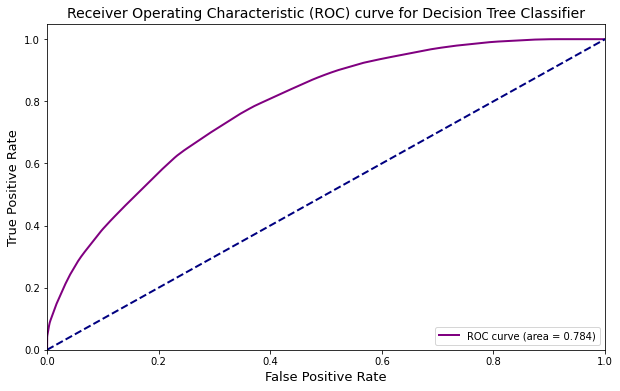

In [56]:
# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_train_resampled, y_prob)
dt_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.3f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic (ROC) curve for Decision Tree Classifier', fontsize=14)
plt.legend(loc="lower right")
plt.savefig(f'roc_dt.svg') 
plt.show()


### RandomForestClassifier FINAL

In [57]:
# only best params
start_time_rf = time.time()

rf_model_final = RandomForestClassifier(bootstrap= True, ccp_alpha= 0.0, class_weight= None, 
                                        criterion= 'gini', max_depth= 10, max_features= 'sqrt', max_leaf_nodes= None, 
                                        max_samples= None, min_impurity_decrease= 0.0, min_samples_leaf= 1, 
                                        min_samples_split= 2, min_weight_fraction_leaf= 0.0, n_estimators= 200, 
                                        n_jobs= None, oob_score= False, random_state= random_state, verbose= 0, warm_start= False)


rf_model_final.fit(X_train_rf, y_train_resampled)
end_time_rf = time.time()

In [58]:
y_pred = rf_model_final.predict(X_train_rf)

# Print the classification report
target_names=['Class 0', 'Class 1']
print(classification_report(y_train_resampled, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.71073   0.67064   0.69011     42568
           1    0.68823   0.72705   0.70711     42568

    accuracy                        0.69885     85136
   macro avg    0.69948   0.69885   0.69861     85136
weighted avg    0.69948   0.69885   0.69861     85136



In [59]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities of the positive class
y_prob = rf_model_final.predict_proba(X_train_rf)[:, 1]

# Calculate the ROC AUC score
roc_auc_rf = roc_auc_score(y_train_resampled, y_prob)

print("ROC AUC Score:", roc_auc_rf)


ROC AUC Score: 0.7747372182663106


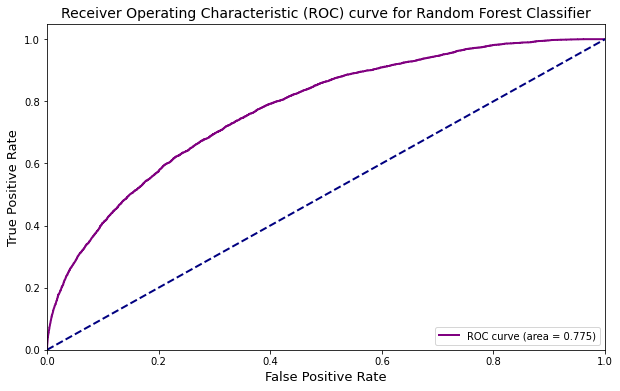

In [61]:
# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_train_resampled, y_prob)
rf_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic (ROC) curve for Random Forest Classifier', fontsize=14)
plt.legend(loc="lower right")
plt.savefig(f'roc_rf.svg') 
plt.show()


In [ ]:
training_time_gb = end_time_gb - start_time_gb
training_time_dt = end_time_dt - start_time_dt
training_time_rf = end_time_rf - start_time_rf

print(f"Training time for Gradient Boosting Classifier: {training_time_gb:.2f} seconds")
print(f"Training time for Decision Tree Classifier: {training_time_dt:.2f} seconds")
print(f"Training time for Random Forest Classifier: {training_time_rf:.2f} seconds")

Training time for Gradient Boosting Classifier: 204.16 seconds
Training time for Decision Tree Classifier: 4.77 seconds
Training time for Random Forest Classifier: 31.23 seconds
